## Zero-shot prediction of *BRCA1* variant effects with Evo 2

The human *BRCA1* gene encodes for a protein that repairs damaged DNA ([Moynahan et al., 1999](https://www.cell.com/molecular-cell/fulltext/S1097-2765%2800%2980202-6)). Certain variants of this gene have been associated with an increased risk of breast and ovarian cancers ([Miki et al., 1994](https://www.science.org/doi/10.1126/science.7545954?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)). Using Evo 2, we can predict whether a particular single nucleotide variant (SNV) of the *BRCA1* gene is likely to be harmful to the protein's function, and thus potentially increase the risk of cancer for the patient with the genetic variant.

We start by loading a dataset from [Findlay et al. (2018)](https://www.nature.com/articles/s41586-018-0461-z), which contains experimentally measured function scores of 3,893 *BRCA1* SNVs. These function scores reflect the extent by which the genetic variant has disrupted the protein's function, with lower scores indicating greater disruption. In this dataset, the SNVs are classified into three categories based on their function scores: `LOF` (loss-of-function), `INT` (intermediate), and `FUNC` (functional). We start by reading in this dataset.

In [1]:
# Install dependencies
!pip install matplotlib pandas seaborn scikit-learn openpyxl

# Required imports
from Bio import SeqIO
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Set root path
os.chdir('../..')

/bin/bash: /home/ggsun/miniconda/envs/evo2-release/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
brca1_df = pd.read_excel(
    os.path.join('notebooks', 'brca1', '41586_2018_461_MOESM3_ESM.xlsx'),
    header=2,
)
brca1_df = brca1_df[[
    'chromosome', 'position (hg19)', 'reference', 'alt', 'function.score.mean', 'func.class',
]]

brca1_df.head(10)

,chromosome,position (hg19),reference,alt,function.score.mean,func.class
0,17,41276135,T,G,-0.372611,FUNC
1,17,41276135,T,C,-0.045313,FUNC
2,17,41276135,T,A,-0.108254,FUNC
3,17,41276134,T,G,-0.277963,FUNC
4,17,41276134,T,C,-0.388414,FUNC
5,17,41276134,T,A,-0.280973,FUNC
6,17,41276133,C,T,-0.973683,INT
7,17,41276133,C,G,-0.373489,FUNC
8,17,41276133,C,A,0.006314,FUNC
9,17,41276132,A,T,-0.207552,FUNC


We then group the `FUNC` and `INT` classes of SNVs together into a single category (`FUNC/INT`).

In [3]:
# Rename columns
brca1_df.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class',
}, inplace=True)

# Convert to two-class system
brca1_df['class'] = brca1_df['class'].replace(['FUNC', 'INT'], 'FUNC/INT')

brca1_df.head(10)

,chrom,pos,ref,alt,score,class
0,17,41276135,T,G,-0.372611,FUNC/INT
1,17,41276135,T,C,-0.045313,FUNC/INT
2,17,41276135,T,A,-0.108254,FUNC/INT
3,17,41276134,T,G,-0.277963,FUNC/INT
4,17,41276134,T,C,-0.388414,FUNC/INT
5,17,41276134,T,A,-0.280973,FUNC/INT
6,17,41276133,C,T,-0.973683,FUNC/INT
7,17,41276133,C,G,-0.373489,FUNC/INT
8,17,41276133,C,A,0.006314,FUNC/INT
9,17,41276132,A,T,-0.207552,FUNC/INT


We build a function to parse the reference and variant sequences of a 8,192-bp window around the genomic position of each SNV, using the reference sequence of human chromosome 17 where *BRCA1* is located.

In [4]:
WINDOW_SIZE = 8192

# Read the reference genome sequence of chromosome 17
with gzip.open(os.path.join('notebooks', 'brca1', 'GRCh37.p13_chr17.fna.gz'), "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_chr17 = str(record.seq)
        break

def parse_sequences(pos, ref, alt):
    """
    Parse reference and variant sequences from the reference genome sequence.
    """
    p = pos - 1 # Convert to 0-indexed position
    full_seq = seq_chr17

    ref_seq_start = max(0, p - WINDOW_SIZE//2)
    ref_seq_end = min(len(full_seq), p + WINDOW_SIZE//2)
    ref_seq = seq_chr17[ref_seq_start:ref_seq_end]
    snv_pos_in_ref = min(WINDOW_SIZE//2, p)
    var_seq = ref_seq[:snv_pos_in_ref] + alt + ref_seq[snv_pos_in_ref+1:]

    # Sanity checks
    assert len(var_seq) == len(ref_seq)
    assert ref_seq[snv_pos_in_ref] == ref
    assert var_seq[snv_pos_in_ref] == alt

    return ref_seq, var_seq

# Parse sequences for the first variant
row = brca1_df.iloc[0]
ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])

print(row)
print('--')
print(f'Reference, SNV 0: ...{ref_seq[4082:4112]}...')
print(f'Variant, SNV 0:   ...{var_seq[4082:4112]}...')

chrom          17
pos      41276135
ref             T
alt             G
score   -0.372611
class    FUNC/INT
Name: 0, dtype: object
--
Reference, SNV 0: ...TGTTCCAATGAACTTTAACACATTAGAAAA...
Variant, SNV 0:   ...TGTTCCAATGAACTGTAACACATTAGAAAA...


Then, we load Evo 2 1B and score the likelihoods of the reference and variant sequences of each SNV. (Note: we use the smaller Evo 2 1B base model here as a quick demonstration, but we strongly recommend using the larger Evo 2 7B and 40B models for more accurate predictions.)

In [5]:
from evo2.models import Evo2

# Load model
model = Evo2('evo2_1b_base')

tokenizers not found, unable to use HFAutoTokenizer


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 220.42it/s]


Extra keys in state_dict: {'blocks.3.mixer.dense._extra_state', 'blocks.24.mixer.dense._extra_state', 'unembed.weight', 'blocks.10.mixer.dense._extra_state', 'blocks.17.mixer.dense._extra_state'}


/home/ggsun/miniconda/envs/evo2-release/lib/python3.12/site-packages/transformer_engine/pytorch/module/base.py:630: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = tor

Loaded model evo2_1b_base from /home/ggsun/.cache/huggingface/hub/models--arcinstitute--evo2_1b_base/snapshots/6915b21845659a78b55e59a1eb603039fc81c49f/evo2_1b_base.pt!


/home/ggsun/evo2/vortex/vortex/model/utils.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch_load(state, map_location=device)


In [6]:
# Build mappings of unique reference sequences
ref_seqs = []
ref_seq_to_index = {}

# Parse sequences and store indexes
ref_seq_indexes = []
var_seqs = []

for _, row in brca1_df.iterrows():
    ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])

    # Get or create index for reference sequence
    if ref_seq not in ref_seq_to_index:
        ref_seq_to_index[ref_seq] = len(ref_seqs)
        ref_seqs.append(ref_seq)
    
    ref_seq_indexes.append(ref_seq_to_index[ref_seq])
    var_seqs.append(var_seq)

ref_seq_indexes = np.array(ref_seq_indexes)

print(f'Scoring likelihoods of {len(ref_seqs)} reference sequences with Evo 2...')
ref_scores = model.score_sequences(ref_seqs)

print(f'Scoring likelihoods of {len(var_seqs)} variant sequences with Evo 2...')
var_scores = model.score_sequences(var_seqs)

Scoring likelihoods of 1326 reference sequences with Evo 2...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1326/1326 [02:20<00:00,  9.45it/s]


Scoring likelihoods of 3893 variant sequences with Evo 2...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3893/3893 [06:49<00:00,  9.51it/s]


We calculate the change in likelihoods for each variant relative to the likelihood of their respective wild-type sequence.

In [7]:
# Subtract score of corresponding reference sequences from scores of variant sequences
delta_scores = np.array(var_scores) - np.array(ref_scores)[ref_seq_indexes]

# Add delta scores to dataframe
brca1_df[f'evo2_delta_score'] = delta_scores

brca1_df.head(10)

,chrom,pos,ref,alt,score,class,evo2_delta_score
0,17,41276135,T,G,-0.372611,FUNC/INT,-0.000054
1,17,41276135,T,C,-0.045313,FUNC/INT,0.000140
2,17,41276135,T,A,-0.108254,FUNC/INT,0.000074
3,17,41276134,T,G,-0.277963,FUNC/INT,-0.000146
4,17,41276134,T,C,-0.388414,FUNC/INT,-0.000104
5,17,41276134,T,A,-0.280973,FUNC/INT,0.000084
6,17,41276133,C,T,-0.973683,FUNC/INT,0.000299
7,17,41276133,C,G,-0.373489,FUNC/INT,0.000077
8,17,41276133,C,A,0.006314,FUNC/INT,0.000352
9,17,41276132,A,T,-0.207552,FUNC/INT,-0.000300


This delta likelihood should be predictive of how disruptive the SNV is to the protein's function: the lower the delta, the more likely that the SNV is disruptive. We can show this by comparing the distributions of delta likelihoods for the two classes of SNVs (functional/intermediate vs loss-of-function).

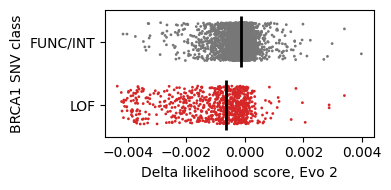

In [8]:
plt.figure(figsize=(4, 2))

# Plot stripplot of distributions
p = sns.stripplot(
    data=brca1_df,
    x='evo2_delta_score',
    y='class',
    hue='class',
    order=['FUNC/INT', 'LOF'],
    palette=['#777777', 'C3'],
    size=2,
    jitter=0.3,
)

# Mark medians from each distribution
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'visible': False},
            medianprops={'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="evo2_delta_score",
            y="class",
            data=brca1_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.xlabel('Delta likelihood score, Evo 2')
plt.ylabel('BRCA1 SNV class')
plt.tight_layout()
plt.show()

We can also calculate the area under the receiver operating characteristic curve (AUROC) of this zero-shot prediction method.

In [9]:
# Calculate AUROC of zero-shot predictions
y_true = (brca1_df['class'] == 'LOF')
auroc = roc_auc_score(y_true, -brca1_df['evo2_delta_score'])

print(f'Zero-shot prediction AUROC: {auroc:.2}')

Zero-shot prediction AUROC: 0.73
